In [2]:
import os
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
from shutil import copyfile

2023-09-23 01:20:03.435809: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-23 01:20:03.471677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 01:20:03.623340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 01:20:03.624205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 01:20:04.512460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
source_path = "/home/atzha99/Terrain-Recognition/Dataset-put-together"

paths = {}

terrains = np.array(["Grassy","Marshy","Sandy","Rocky"])

for i in terrains:
  paths[i] = os.path.join(source_path, i)
  print(f"Number of images in {i} directory : "+str(len(os.listdir(paths[i]))))

Number of images in Grassy directory : 12160
Number of images in Marshy directory : 11040
Number of images in Sandy directory : 10950
Number of images in Rocky directory : 10955


In [5]:
base_dir = "/home/atzha99/Terrain-Recognition/Dataset"

if os.path.exists(base_dir):
  shutil.rmtree(base_dir)

def mk_train_val_dirs(base_path):
  for i in terrains :
    os.makedirs(os.path.join(base_path,'training/'+i))
    os.makedirs(os.path.join(base_path,'validation/'+i))

mk_train_val_dirs(base_dir)

In [6]:
for rootdir, dirs, files in os.walk(base_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/home/atzha99/Terrain-Recognition/Dataset/training
/home/atzha99/Terrain-Recognition/Dataset/validation
/home/atzha99/Terrain-Recognition/Dataset/training/Sandy
/home/atzha99/Terrain-Recognition/Dataset/training/Rocky
/home/atzha99/Terrain-Recognition/Dataset/training/Grassy
/home/atzha99/Terrain-Recognition/Dataset/training/Marshy
/home/atzha99/Terrain-Recognition/Dataset/validation/Sandy
/home/atzha99/Terrain-Recognition/Dataset/validation/Rocky
/home/atzha99/Terrain-Recognition/Dataset/validation/Grassy
/home/atzha99/Terrain-Recognition/Dataset/validation/Marshy


In [7]:
import random
from tensorflow.keras.utils import load_img, img_to_array

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  raw_data = os.listdir(SOURCE_DIR)
  clean_data = []
  for i in raw_data :
    if os.path.getsize(os.path.join(SOURCE_DIR,i))==0 :
      print(i+" is zero length, so ignoring.")
    else :
      clean_data.append(i)

  len_clean_data = len(clean_data)
  len_train_data = len_clean_data*SPLIT_SIZE
  train_data = random.sample(clean_data, int(len_train_data))
  for i in train_data :
    copyfile(os.path.join(SOURCE_DIR,i),os.path.join(TRAINING_DIR,i))
  for i in clean_data :
    if i not in train_data :
      copyfile(os.path.join(SOURCE_DIR,i),os.path.join(VALIDATION_DIR,i))


In [8]:
TRAINING_DIR = "/home/atzha99/Terrain-Recognition/Dataset/training"
VALIDATION_DIR = "/home/atzha99/Terrain-Recognition/Dataset/validation"

SOURCE_DIR = "/home/atzha99/Terrain-Recognition/Dataset-put-together"

# Empty directories in case you run this cell multiple times

for i in terrains :
  if len(os.listdir(os.path.join(TRAINING_DIR,i))) > 0:
    for file in os.scandir(os.path.join(TRAINING_DIR,i)):
      os.remove(file.path)
  if len(os.listdir(os.path.join(VALIDATION_DIR,i))) > 0:
    for file in os.scandir(os.path.join(VALIDATION_DIR,i)):
      os.remove(file.path)


# Define proportion of images used for training
split_size = .7

# Run the function
# NOTE: Messages about zero length images should be printed out
for i in terrains :
  split_data(os.path.join(SOURCE_DIR,i), os.path.join(TRAINING_DIR,i), os.path.join(VALIDATION_DIR,i), split_size)


for i in terrains:
  print(f"Source {i} directory has {len(os.listdir(os.path.join(SOURCE_DIR,i)))} images")
  print(f"Training {i} directory has {len(os.listdir(os.path.join(TRAINING_DIR,i)))} images")
  print(f"Validation {i} directory has {len(os.listdir(os.path.join(VALIDATION_DIR,i)))} images\n")

Source Grassy directory has 12160 images
Training Grassy directory has 8512 images
Validation Grassy directory has 3648 images

Source Marshy directory has 11040 images
Training Marshy directory has 7727 images
Validation Marshy directory has 3313 images

Source Sandy directory has 10950 images
Training Sandy directory has 7664 images
Validation Sandy directory has 3286 images

Source Rocky directory has 10955 images
Training Rocky directory has 7668 images
Validation Rocky directory has 3287 images



In [9]:
from keras.preprocessing.image import ImageDataGenerator
training_images = ImageDataGenerator(rescale=1./255.,
                                      fill_mode='nearest')

train_generator = training_images.flow_from_directory("/home/atzha99/Terrain-Recognition/Dataset/training",
                                                      target_size=(28,28))

validation_images = ImageDataGenerator(rescale=1./255.,
                                      fill_mode='nearest')

val_generator = validation_images.flow_from_directory("/home/atzha99/Terrain-Recognition/Dataset/validation",
                                                      shuffle = False,
                                                      target_size=(28,28))

Found 31571 images belonging to 4 classes.
Found 13534 images belonging to 4 classes.


In [10]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('/home/atzha99/Terrain-Recognition/Model/TerrainNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(4,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',
                                                                        tf.keras.metrics.Precision(),
                                                                        tf.keras.metrics.Recall()])

history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    epochs=30,
                    callbacks=[model_ckpt,reduce_lr,early_stop],
                    verbose=1)

Epoch 1/30


2023-09-23 01:22:56.494778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


987/987 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.7399 - precision: 0.8013 - recall: 0.6691

2023-09-23 01:24:00.541264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


987/987 [==============================] - 90s 90ms/step - loss: 0.6069 - accuracy: 0.7399 - precision: 0.8013 - recall: 0.6691 - val_loss: 0.4529 - val_accuracy: 0.8208 - val_precision: 0.8325 - val_recall: 0.8053 - lr: 0.0010
Epoch 2/30
987/987 [==============================] - 84s 85ms/step - loss: 0.4305 - accuracy: 0.8231 - precision: 0.8393 - recall: 0.8023 - val_loss: 0.3656 - val_accuracy: 0.8505 - val_precision: 0.8681 - val_recall: 0.8348 - lr: 0.0010
Epoch 3/30
987/987 [==============================] - 85s 86ms/step - loss: 0.3495 - accuracy: 0.8680 - precision: 0.8799 - recall: 0.8544 - val_loss: 0.2908 - val_accuracy: 0.8943 - val_precision: 0.9058 - val_recall: 0.8836 - lr: 0.0010
Epoch 4/30
987/987 [==============================] - 82s 83ms/step - loss: 0.2981 - accuracy: 0.8902 - precision: 0.9002 - recall: 0.8819 - val_loss: 0.2862 - val_accuracy: 0.8890 - val_precision: 0.8948 - val_recall: 0.8837 - lr: 0.0010
Epoch 5/30
987/987 [==============================] - 8

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 64)       283       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 128)      8896      
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                         

In [12]:
model = load_model('/home/atzha99/Terrain-Recognition/Model/TerrainNet.h5')
acc = model.evaluate(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

2023-09-23 02:01:31.965135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


423/423 [==============================] - 22s 52ms/step - loss: 0.0949 - accuracy: 0.9703 - precision: 0.9709 - recall: 0.9699
model accuracy: 0.9703


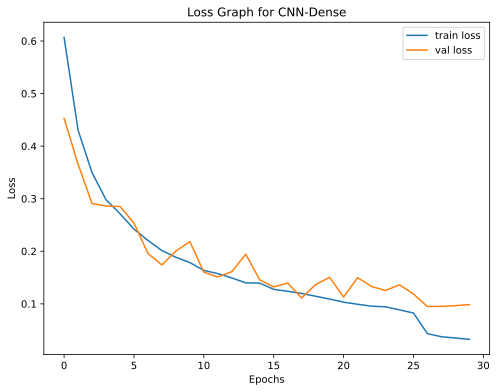

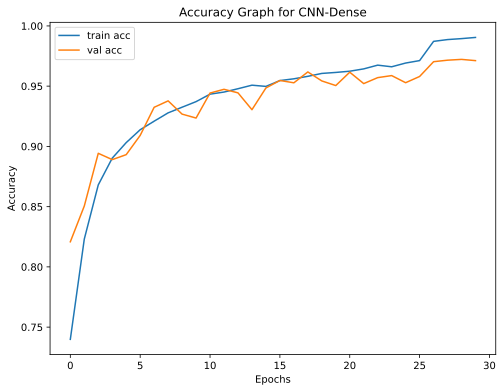

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss Graph for CNN-Dense")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss Graph.png')
plt.show()


# plot the accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy Graph for CNN-Dense")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Accuracy Graph.png')
plt.show()

In [14]:
pred = model.predict(val_generator)
pred

  2/423 [..............................] - ETA: 22s

2023-09-23 02:01:54.754932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


423/423 [==============================] - 22s 52ms/step


array([[7.0986837e-01, 2.8952628e-01, 6.0524116e-04, 1.1019570e-07],
       [9.0175682e-01, 9.0217955e-02, 8.0186957e-03, 6.5168724e-06],
       [9.4177157e-01, 4.5385163e-02, 1.2836252e-02, 7.0056526e-06],
       ...,
       [4.3618890e-11, 1.5622110e-05, 3.7077771e-05, 9.9994731e-01],
       [1.8388775e-10, 3.9375143e-05, 1.1416643e-04, 9.9984646e-01],
       [4.1426599e-08, 8.8753313e-04, 5.7895458e-04, 9.9853349e-01]],
      dtype=float32)

Trying out predict from sci-kit learn

Double checking the accuracy value using the *accuracy_score* function from the $scikit-learn$ library

In [15]:
from sklearn.metrics import accuracy_score

predicted_labels = pred.argmax(axis=-1)

real_labels = val_generator.classes

acc = accuracy_score(predicted_labels, real_labels)

print(round(acc*100,2),"%",sep="")

97.03%


In [16]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/home/atzha99/Terrain-Recognition/Dataset-put-together/Marshy/Marshy (1)_0_3.png')

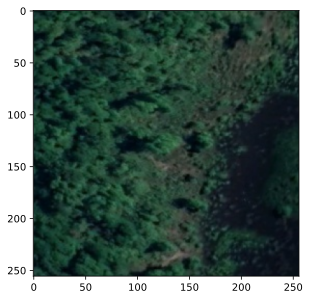

In [17]:
plt.imshow(img)

In [18]:
import cv2

x=image.img_to_array(img)
x=cv2.resize(x, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)
x

array([[[30.795918 , 61.72959  , 56.79592  ],
        [ 9.32653  , 38.382652 , 33.214287 ],
        [17.612244 , 52.734695 , 35.89796  ],
        ...,
        [61.433674 , 71.52551  , 62.47959  ],
        [48.198982 , 77.19898  , 59.198982 ],
        [17.306124 , 41.59184  , 27.520409 ]],

       [[26.862246 , 65.86224  , 44.862244 ],
        [39.15306  , 82.89286  , 56.367348 ],
        [47.07143  , 82.79082  , 61.005104 ],
        ...,
        [50.285713 , 64.85714  , 52.214283 ],
        [49.65306  , 68.67347  , 57.10204  ],
        [36.158165 , 66.51531  , 51.72959  ]],

       [[ 4.3622446, 17.979591 , 21.836735 ],
        [ 4.4591837, 30.887754 , 19.959185 ],
        [56.25     , 93.69388  , 67.765305 ],
        ...,
        [42.55612  , 64.301025 , 51.42857  ],
        [68.55612  , 80.55612  , 66.55612  ],
        [32.77551  , 55.84694  , 46.295918 ]],

       ...,

       [[13.290816 , 35.69898  , 31.627552 ],
        [30.47449  , 70.90306  , 61.688774 ],
        [25.42347  , 6

In [19]:
x.shape

(28, 28, 3)

In [20]:
x=np.expand_dims(x,axis=0)
model.predict(x)

1/1 [==============================] - 0s 53ms/step


array([[1., 0., 0., 0.]], dtype=float32)

In [21]:
a=np.argmax(model.predict(x), axis=1)
a

1/1 [==============================] - 0s 11ms/step


array([0])

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

In [23]:
conf_matrix1 = tf.math.confusion_matrix(
    real_labels,
    predicted_labels,
    num_classes=4,
    dtype=tf.dtypes.int32,
    name="Confusion matrix for CNN"
)
conf_matrix1

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[3574,   57,   17,    0],
       [  36, 3173,   96,    8],
       [  14,  133, 3130,   10],
       [   0,    5,   26, 3255]], dtype=int32)>

In [30]:
# cmatrix1_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix1)
# cmatrix1_display.plot()

In [24]:
real_labels_alpha = [terrains[i] for i in real_labels]
predicted_labels_alpha = [terrains[i] for i in predicted_labels]

In [25]:
conf_matrix2 = confusion_matrix(real_labels_alpha, predicted_labels_alpha)
conf_matrix2

array([[3574,   57,    0,   17],
       [  36, 3173,    8,   96],
       [   0,    5, 3255,   26],
       [  14,  133,   10, 3130]])

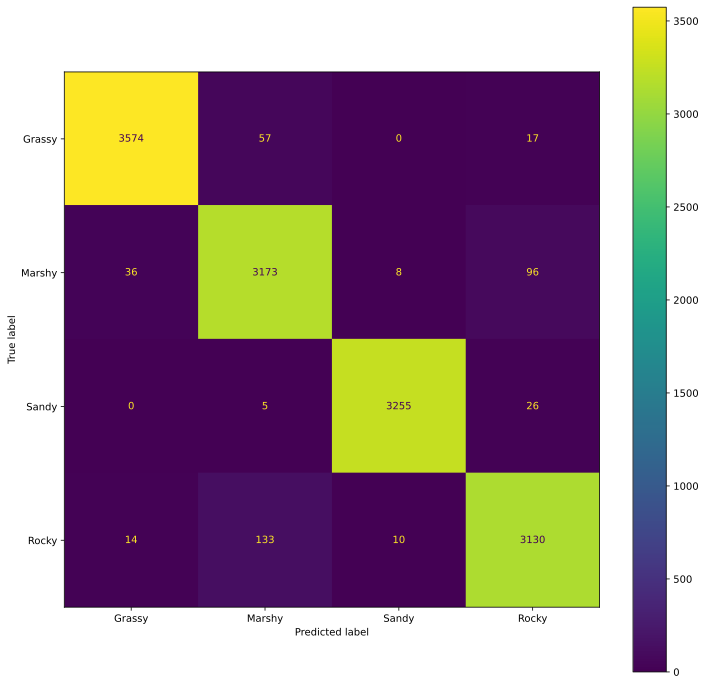

In [26]:
cmatrix2_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2, display_labels=terrains)
fig, ax = plt.subplots(figsize=(12, 12)) 
cmatrix2_display.plot(ax=ax)
plt.savefig('confusion_matrix.png')

In [27]:
from sklearn.preprocessing import LabelBinarizer

train_labels = train_generator.classes
train_labels = [terrains[i] for i in train_labels]

val_labels = real_labels
val_labels = [terrains[i] for i in val_labels]

label_binarizer = LabelBinarizer().fit(train_labels)
y_onehot_test = label_binarizer.transform(val_labels)
y_onehot_test.shape  # (n_samples, n_classes)

(13534, 4)

In [28]:
label_binarizer.transform(["Sandy"])

array([[0, 0, 0, 1]])

In [29]:
class_of_interest = "Marshy"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

1

/tmp/ipykernel_51671/1980473596.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab20")


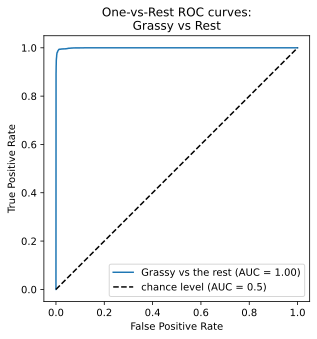

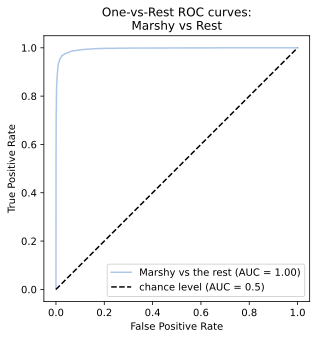

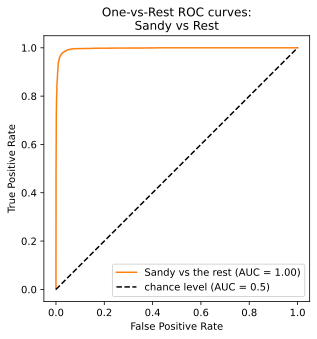

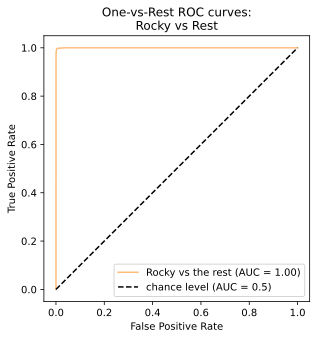

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from matplotlib.cm import get_cmap

cmap = get_cmap("tab20")
num_colors = 20 

for i,class_of_interest in enumerate(terrains):
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
  class_idn = list(terrains).index(class_of_interest)
  RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_id],
      pred[:, class_idn],
      name=f"{class_of_interest} vs the rest",
      color=cmap(i % num_colors)
  )
      
  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs Rest")
  plt.legend()
  plt.savefig(f"{class_of_interest} vs Rest")
  

/tmp/ipykernel_51671/3929032553.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab20")  # Choose a colormap


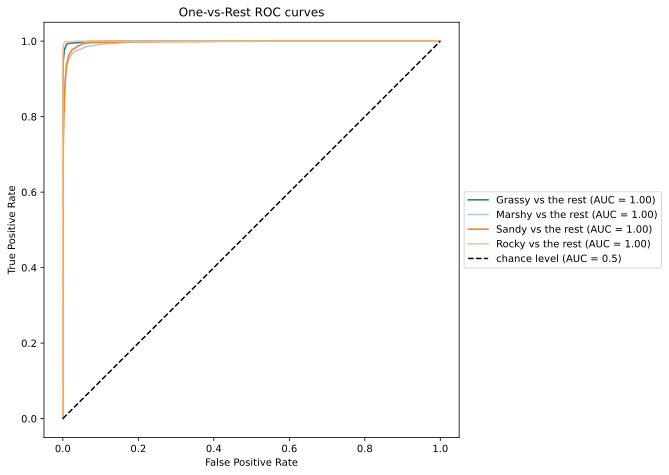

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from matplotlib.cm import get_cmap

fig, ax = plt.subplots(figsize=(12, 7.5))  # Create a figure and axes

cmap = get_cmap("tab20")  # Choose a colormap
num_colors = 20  # Number of distinct colors needed

for i, class_of_interest in enumerate(terrains):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_idn = list(terrains).index(class_of_interest)
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        pred[:, class_idn],
        name=f"{class_of_interest} vs the rest",
        color=cmap(i % num_colors),  # Use a unique color from the colormap
        ax=ax  # Use the same axes for all plots
    )

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Move the legend outside the graph
plt.savefig("One-vs-Rest ROC curves")
plt.show()